In [3]:
import numpy as np

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output, display
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# Recursion

+ As we saw in the notes and readings, recursions have base cases and inductive cases
+ When writing a recursive function, we should start with our base cases, where we know what the correct return looks like
+ When working with graphs or trees, we often encounter recursion due to the need to perform depth-first search
+ Inductive reasoning: write a case for $N + 1$ in terms of $N$, $N - 1$, etc
+ Dynamic programming vs recursion: in DP, we find the Nth case solution by starting with the base cases, and iterating forward until we hit our target $N$. In recursion, we work backwards from $N$ until we hit a base case


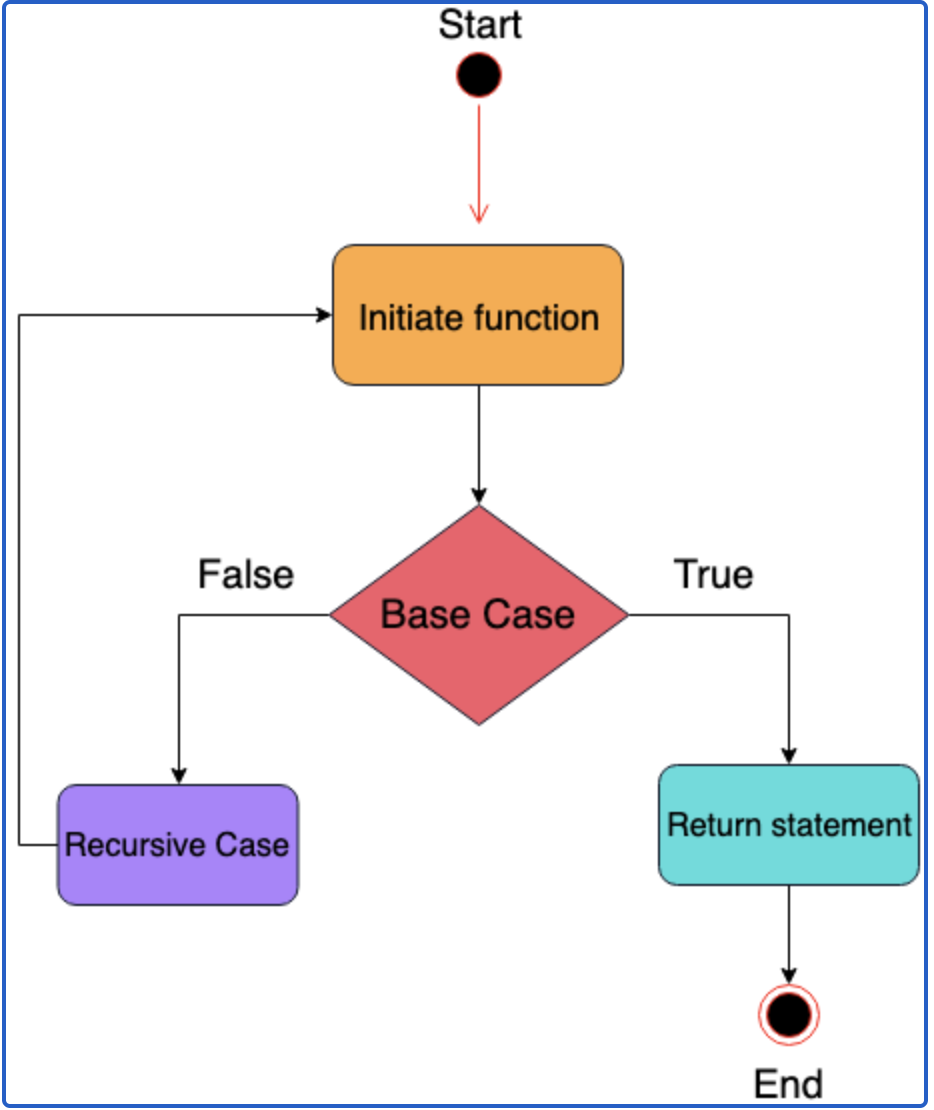

In [5]:
Image("../resources/recursion.png", width=500)
# Source: https://betterprogramming.pub/recursive-functions-2b5ce4610c81

Text(0, 0.5, 'Time (s)')

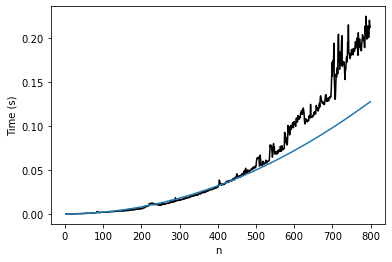

In [30]:
def factorial(n):
    """Compute n factorial, for n >= 0."""
    # Base case
    if n == 0:
        return 1
    # Recursive case
    else:
        return n * factorial(n - 1)

import timeit

nvals = np.arange(2, 800)
all_times = list()
for n in nvals:
    all_times.append(
        timeit.timeit("factorial(n)", globals=globals(), number=n)
    )

plt.figure()
plt.plot(nvals, all_times, 'k')
plt.plot(nvals, 2e-7 * nvals**2)
plt.xlabel("n")
plt.ylabel("Time (s)")


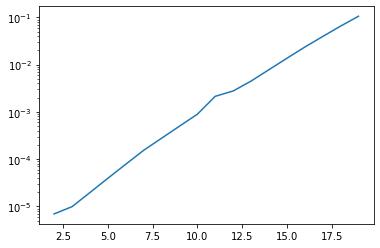

In [36]:
def fibonacci(n):
    """Compute the nth Fibonacci number, for n >= 0."""
    # Base cases
    if n == 0:
        return 0
    elif n == 1:
        return 1

    # Recursive case
    else:
        return fibonacci(n - 1) + fibonacci(n - 2)

nvals = np.arange(2, 20)
all_times = list()
for n in nvals:
    all_times.append(
        timeit.timeit("fibonacci(n)", globals=globals(), number=n)
    )
plt.semilogy(nvals, all_times)


# The discrete Fourier Transform

We are going to implement possibly the most important algorithm of the 20th century, the fast Fourier transform. This algorithm allows signals to be readily transformed into the frequency domain, a setting where it is easier to filter noise, detect background patterns, and identify significant motifs

A discrete approach to this algorithm involves projecting our signal onto a set of "pure" basis functions corresponding to single-frequency (monochromatic) signals. In continuous time, we would have a continuous and uncountable set of frequencies, but for a discrete signal we have a finite number of possible frequency bins.

If our observed signal is $x_n = x_1, x_2, ..., x_N$, then the discrete Fourier transform becomes
$$
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N}
$$
with corresponding inverse transform
$$
x_n = \frac{1}{N}\sum_{k=0}^{N-1} X_k e^{i~2\pi~k~n~/~N}
$$
In our naive implementation below, we compute the set of "pure" functions, and then project the signal onto this basis. This approach is easy to vectorize, since all operations that touch all $N$ elements of the signal can be written as dot products.

In matrix notation, the vectorized DFT is given by
$$
\mathbf{X} = M \cdot \mathbf{x}
$$
where
$$
M_{kn} = e^{-i~2\pi~k~n~/~N}.
$$

### A symmetry in the discrete equations

The key idea of the fast Fourier transform is based on the observation that this calculation has an even-odd symmetry. If we shift our Fourier transform calculation above in order to find $X_{N+k}$, the calculation becomes
$$
\begin{align*}
X_{N + k} &=  \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~(N + k)~n~/~N}\\
          &= \sum_{n=0}^{N-1} x_n \cdot e^{- i~2\pi~n} \cdot e^{-i~2\pi~k~n~/~N}\\
          &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N}
\end{align*}
$$
because $\exp[2\pi~i~n] = 1$ for all $n$. Using this property, we can derive the following symmetry
$$
X_{k + i \cdot N} = X_k
$$

### The fast Fourier transform

As a result of the symmetry above, it's possible to divide our Fourier transform calculation into two parts,
$$
\begin{align*}
X_k &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~(2m)~/~N} + \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~(2m + 1)~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~m~/~(N/2)} + e^{-i~2\pi~k~/~N} \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~m~/~(N/2)}
\end{align*}
$$

Since our argument does not depend on the specific value of $n$, we now have a clear way to attack this problem: given a full signal on which to compute the FFT, split the signal into two smaller signals, and then call the Fourier transform calculation on each of the two subarrays. If either subarray is larger than size 2, then divide it again. If it's equal in length to 2 or less, then compute the discrete Fourier transform, which has a simple form for signals of length one and two.

This approach is naturally suited to recursion, with the short length-1 and length-2 signal cases representing base cases for returns. This appraoch is known as divide-and-conquer.

While the vanilla DFT has runtime complexity $N^2$ due to the need to compute $N$ dot products for each of the $N$ pure frequency components, the FFT has runtime $N \log N$ because it reduces the problem in each step



*This notebook was adapted from [Jake VanderPlas's excellent tutorial](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/)*


+ Notice that our base class includes a freq_bounds function. Where do these bounds come from?

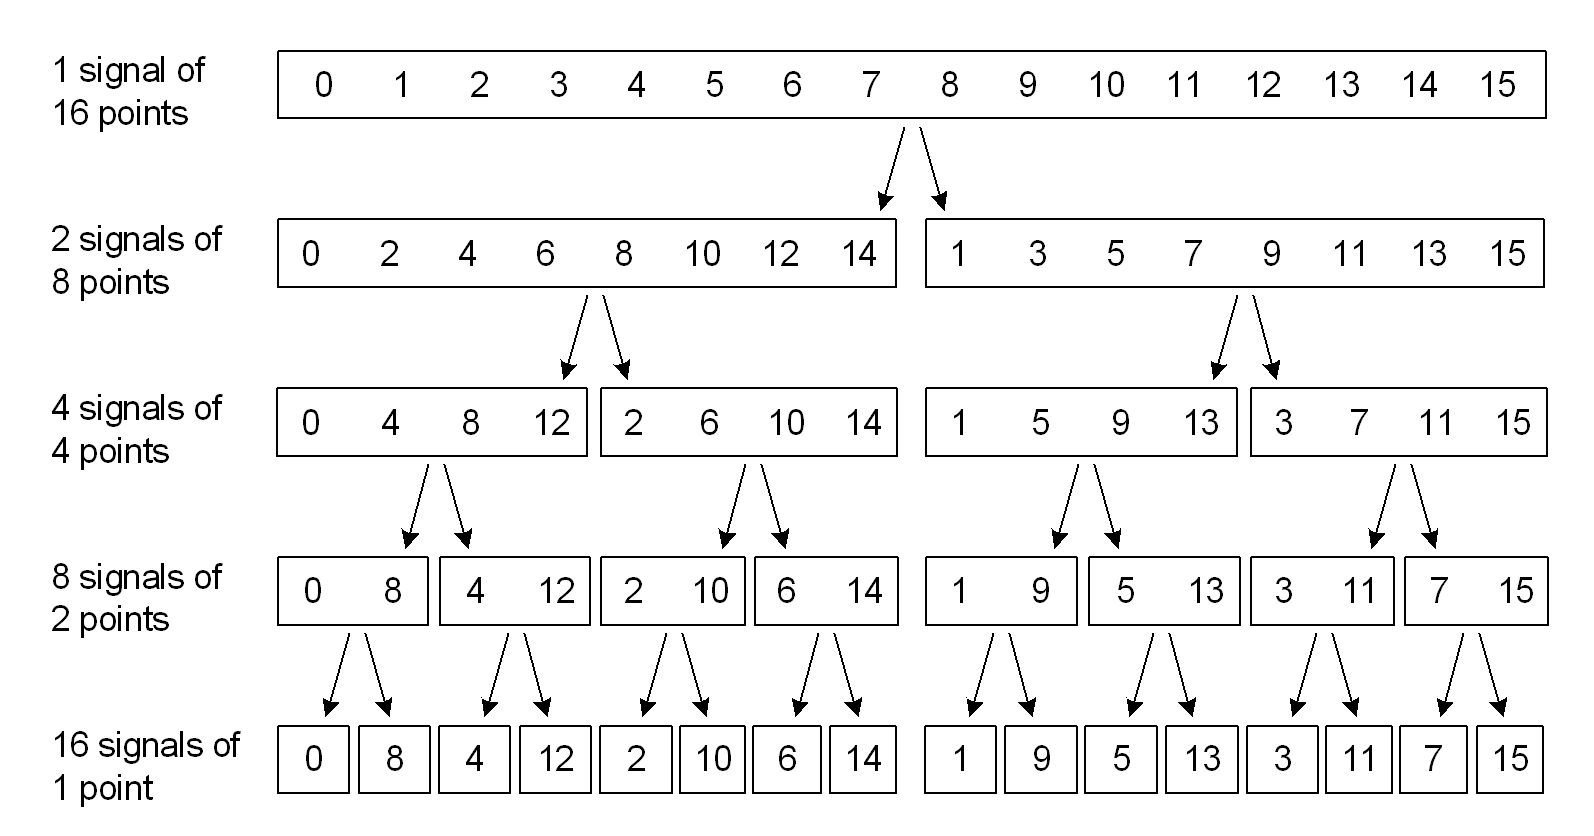

In [34]:
Image("../resources/fft.png")
# Source: https://riptutorial.com/algorithm/example/27088/radix-2-fft

In [2]:
class SignalTransform:
    """
    A base class for signal transformations

    Parameters:
        center (bool): whether to center the signal before transforming
    """
    
    def __init__(self, center=True):
        self.center = center
        
    def preprocess(self, signal):
        if self.center:
            signal -= np.mean(signal, axis=0, keepdims=True)
    
    # static methods don't require a "self" argument, but also can't 
    # access instance attributes. For example, this function can't see the 
    # self.center variable that we set in the __init__() constructor 
    @staticmethod
    def freq_bounds(signal):
        """Compute upper and lower frequency bounds using the Nyquist criterion"""
        n = len(signal)
        return 1 / (2 * n), n / 2

    def plot(self, signal, ax=None, **kwargs):
        """Plot the signal in the time domain"""
        if ax is None:
            ax = plt.gca()
        ax.plot(signal, **kwargs)
        ax.set_xlabel('Time')
        ax.set_ylabel('Amplitude')
        ax.set_title('Time Domain')
        return ax

    def plot_freq(self, signal, ax=None, **kwargs):
        """Plot the signal in the frequency domain"""
        if ax is None:
            ax = plt.gca()
        freq = np.fft.rfftfreq(len(signal))
        ax.plot(freq, np.abs(np.fft.rfft(signal)), **kwargs)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Amplitude')
        ax.set_title('Frequency Domain')
        return ax

        
# There's another way to do this as of Python 3.7 (released in June 2018)
# https://docs.python.org/3/library/dataclasses.html
# dataclasses are useful if you are setting a lot of kwargs in the constructor
# child classes initialize *first*, althoug this can be avoided by using the 
# newly-introduced __post_init__ function

# from dataclasses import dataclass
# @dataclass
# class SignalTransform:
#     center: bool = True




class DiscreteFourierTransform(SignalTransform):
    """
    An iterative implementation of the discrete Fourier transform

    Vectorized using array broadcasting
    """
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def transform(self, signal):
        """Compute the discrete Fourier transform of a signal"""
        
        n = len(signal)
        k_vals = np.arange(n)[:, None]
        
        # Python has built-in complex numbers, which numpy supports
        coeffs = np.exp(-2j * np.pi * k_vals * np.arange(n) / n)
        
        return np.dot(coeffs, signal)
    
    
    
class FastFourierTransform(SignalTransform):
    """
    A recursive implementation of the fast Fourier transform
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def transform(self, signal):
        
        n = len(signal)
        
        if n == 1:  # base case
            return signal
        else:
            signal_even = self.transform(signal[::2])
            signal_odd = self.transform(signal[1::2])
            coeffs = np.exp(-2j * np.pi * np.arange(n) / n)
            signal_new =  np.hstack([
                signal_even + coeffs[:(n // 2)] * signal_odd,
                signal_even + coeffs[(n // 2):] * signal_odd
            ])
            return signal_new


In [3]:
x = np.random.random(2**10) # Needs to be a power of 2

dft_m = DiscreteFourierTransform()
%timeit dft_m.transform(x) 
print(np.allclose(dft_m.transform(x), np.fft.fft(x)))

fft_m = FastFourierTransform()
%timeit fft_m.transform(x) 
print(np.allclose(fft_m.transform(x), np.fft.fft(x)))

25.2 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
True
10.4 ms ± 298 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True


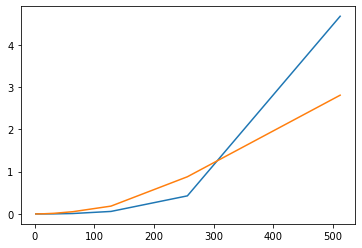

In [28]:
import timeit

n_vals = 2**np.arange(1, 10)

x = np.random.random(2**11) # Needs to be a power of 2
dft_m = DiscreteFourierTransform()
fft_m = FastFourierTransform()

all_times = []
for n in n_vals:
    time1 = timeit.timeit("dft_m.transform(x[:n])", globals=globals(), number=n)
    time2 = timeit.timeit("fft_m.transform(x[:n])", globals=globals(), number=n)
    all_times.append([time1, time2])
all_times = np.array(all_times)

plt.figure()
plt.plot(n_vals, all_times[:, 0])
plt.plot(n_vals, all_times[:, 1])